# Traing MPDR for 2D density estimation  (MPDR-R)

* and save results for visualization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

from loader.synthetic import sample2d
from models.mpdr import MPDR_Single, AE
from models.modules import FCNet
from ipywidgets import Output
from IPython.display import clear_output

from models.mmd import mmd

In [3]:
dset = '8gaussians'
xmin, xmax, ymin, ymax = [-4, 4, -4, 4]
batch_size = 200
device = 'cuda:0'

In [4]:
XX, YY = torch.meshgrid(torch.linspace(xmin, xmax, 100), torch.linspace(ymin,ymax, 100))
grid = torch.cat([XX.reshape(-1,1), YY.reshape(-1,1)], dim=1)
grid_gpu = grid.to(device)

/opt/conda/envs/nae/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor(1., dtype=torch.float64)


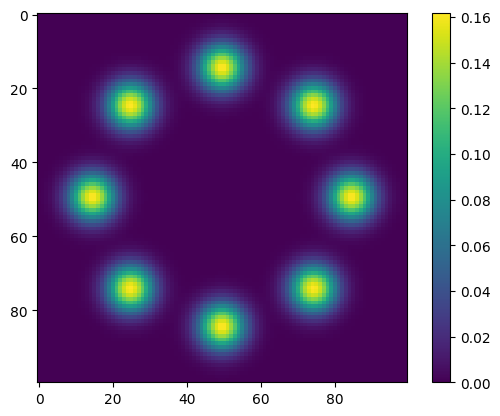

In [5]:
'''compute 8 gaussains pdf normalized in (4,-4)'''
from loader.synthetic import pdf_8gaussian
p_8gaussian = pdf_8gaussian(grid)
p_8gaussian /= (p_8gaussian * (8/100 * 8 / 100)).sum()
print((p_8gaussian * (8/100 * 8 / 100)).sum())

p_8gaussian = p_8gaussian.reshape(100,100)

plt.imshow(p_8gaussian)
plt.colorbar()

In [6]:
Xgrid, Ygrid = torch.meshgrid(torch.torch.linspace(-4, 4, 10), torch.linspace(-4, 4, 10))
grid2d = torch.stack([Xgrid.flatten(), Ygrid.flatten()]).T

### MPDR-R

In [21]:
# autoencoder for manifold
zdim = 2
encoder = FCNet(in_dim=2, out_dim=zdim, l_hidden=[128, 128], out_activation='linear', activation='relu')
decoder = FCNet(in_dim=zdim, out_dim=2, l_hidden=[128, 128], out_activation='linear', activation='relu')
ae = AE(encoder, decoder, l2_norm_reg_enc=0.0001, encoding_noise=None, spherical=True)

# autoencoder for the energy function
zdim = 3
encoder = FCNet(in_dim=2, out_dim=zdim, l_hidden=[128, 128, 128], out_activation='linear', activation='relu')
decoder = FCNet(in_dim=zdim, out_dim=2, l_hidden=[128, 128, 128], out_activation='linear', activation='relu')
ae2 = AE(encoder, decoder, l2_norm_reg_enc=0.0001, encoding_noise=None, spherical=True, learn_out_scale=True)

varnet_x = ae2

nae = MPDR_Single(ae=ae, net_x=varnet_x,
                sampling_x='langevin',
                mcmc_n_step_x=10, mcmc_stepsize_x=1., mcmc_noise_x=0.15, mh_x=False,
                mcmc_n_step_omi=2, mcmc_stepsize_omi=0.1, mcmc_noise_omi=0.02, mcmc_normalize_omi=True,
                gamma_vx=None, gamma_neg_recon=1,
                temperature=1., 
                proj_mode='uniform', proj_noise_start=0.05, proj_noise_end=0.3, proj_const=0.0001,
                custom_netx_reg=True
                )
nae.to(device)

opt1 = Adam(nae.ae.parameters(), lr=1e-3)
opt2 = Adam(list(nae.net_x.encoder.parameters()) + list(nae.net_x.decoder.parameters()), lr=1e-3)
opt3 = Adam(list(nae.net_x.parameters()), lr=1e-4)
l_loss = []
l_loss_ae1 = []; l_loss_ae2 = []; 
l_mmd = []; l_mae = []
l_temperature = []
l_pos = []; l_neg = []; l_logvar = []; l_pos_on = []; l_neg_on = []; l_pos_om = []; l_neg_om = []
l_gamma_vs = []; l_gamma_vx = [];
l_ae_neg = []
l_i = []; l_mmd_sample = []; l_mmd_init = []

In [22]:
'''AE pass'''
out = Output()
display(out)
n_iter = 300
for i_iter in tqdm(range(n_iter)):
    batch_x = sample2d(dset, batch_size=batch_size)
    batch_x = torch.tensor(batch_x, dtype=torch.float, device=device)
    d_train = nae.train_step_ae(batch_x, opt1)
    l_loss_ae1.append(d_train['loss/train_loss_ae_'])

    if i_iter % 50 == 0:
        with out:
            batch_x = batch_x.cpu()

            out.clear_output(wait=True)
            fig, axs = plt.subplots(ncols=2, figsize=(8,4))
            axs[0].plot(l_loss_ae1); axs[0].set_title('loss')
            plt.tight_layout()
            plt.show()

Output()

  0%|          | 0/300 [00:00<?, ?it/s]

In [23]:
'''netx pass'''
out = Output()
display(out)
n_iter = 500
for i_iter in tqdm(range(n_iter)):
    batch_x = sample2d(dset, batch_size=batch_size)
    batch_x = torch.tensor(batch_x, dtype=torch.float, device=device)
    d_train = nae.net_x.train_step(batch_x, opt2)
    l_loss_ae2.append(d_train['loss/train_loss_ae_'])

    if i_iter % 50 == 0:
        with out:
            batch_x = batch_x.cpu()

            out.clear_output(wait=True)
            fig, axs = plt.subplots(ncols=2, figsize=(8,4))
            axs[0].plot(l_loss_ae2); axs[0].set_title('loss')
            plt.tight_layout()
            plt.show()

Output()

  0%|          | 0/500 [00:00<?, ?it/s]

## MPDR Training

In [24]:
n_iter = 4000
out = Output()
display(out)
for i_iter in tqdm(range(n_iter)):
    batch_x = sample2d(dset, batch_size=batch_size)
    batch_x = torch.tensor(batch_x, dtype=torch.float, device=device)
    d_train = nae.train_step(batch_x, opt3)
    l_loss.append(d_train['loss'])
    l_pos.append(d_train['mpdr/off_pos_e_']); l_neg.append(d_train['mpdr/off_neg_e_'])
    l_gamma_vx.append(d_train['reg/reg_gamma_vx_'])
    
    if i_iter % 200 == 0:
        batch_x = batch_x.cpu()
        
        with out:
            nae.eval()
            clear_output(wait=True)
            fig, axs = plt.subplots(ncols=6, figsize=(24,4))
            axs[0].plot(l_loss, label='loss'); axs[0].set_title('loss')
            axs[0].legend(loc=2)
            ax2 = axs[0].twinx()
            ax2.plot(l_ae_neg, 'r', label='ae_neg_loss'); ax2.legend(loc=3)

            recon = nae.decode(nae.encode(grid2d.to(device))).detach().cpu().numpy()
            axs[1].plot(np.stack([grid2d[:,0], recon[:,0]]), np.stack([grid2d[:,1], recon[:,1]]), 'k--');        
            axs[1].scatter(grid2d[:,0].numpy(), grid2d[:,1].numpy(), marker='o', color='k');        
            axs[1].set_title('recon')
            
            axs[2].plot(l_pos, label='pos_e')
            axs[2].plot(l_neg, label='neg_e')
            axs[2].plot(l_gamma_vx, label='gamma_vx')
            axs[2].legend()

            x_neg_off = d_train['x_neg'].detach().cpu()
            mmd_ = mmd(batch_x.to(device), x_neg_off.to(device), bandwidth=0.1).item()
            axs[3].plot(batch_x[:,0], batch_x[:,1], '.', label='pos')
            axs[3].plot(x_neg_off[:,0], x_neg_off[:,1], '.', label='neg')
            axs[3].legend()
            axs[3].set_title(f'MMD: {mmd_:.4f}')
            
            T = nae.temperature
            E = nae.energy_x(grid_gpu, 0).detach().cpu().reshape(100, 100) 
            Omega = ((8 / 100 * 8 / 100) * np.exp(-E / T)).sum()
            p_theta = np.exp(-E / T) / Omega
            mae = np.abs(p_theta - p_8gaussian).mean()
            l_mae.append(mae)
            
            axs[4].set_title(f'MAE: {mae:.5f}')
            axs[4].plot(l_mae)
            
            img = axs[5].imshow(p_theta, origin='lower', extent=(-4, 4, -4, 4))
            fig.colorbar(img, ax=axs[5])
            plt.tight_layout()
            plt.show()

Output()

  0%|          | 0/4000 [00:00<?, ?it/s]

In [163]:
torch.save(p_theta, 'p_theta_mpdr_ae_hybrid_8gaussian.pkl')

In [164]:
torch.save(E, 'E_mpdr_ae_hybrid_8gaussian.pkl')

In [ ]:
torch.save(nae.state_dict(), f'mpdr_ae_hybrid_8gaussian.pth')